# import

In [143]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from ast import literal_eval
import scipy
import json 
#functions

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)

def load_in_sleep_state_scoring(mouse):
    # print('---------------------')
    # print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                # print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            # print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "presleep_nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "presleep_rem_start_ends.npy", allow_pickle=True)
    #     print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    # print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times


# PRESLEEP ANALYSIS 

In [144]:

# load in the presleep data - extract number of sequenes found
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\"
presleep_events_per_min = []
mirs = []

# load in sleep time points
sleep_time_point_df = pd.read_csv(r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\sleep_time_points.csv')
# decide when sleep started
sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value

for iteration_ in tqdm(range(len(os.listdir(PP_PATH)[3::]))):
    
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    
    
    total_event = 0
    all_chunks_len = 0
    
    
 
    # load in sleep start time 
    current_sleep_start = sleep_start[file_.split('_run')[0]]
    params_file = PP_PATH + file_ + r'\trainingData\\' + 'params_' + file_.split('_run')[0] + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
                

    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            print(len(replay_clusts))
            if 'ordering_classification' in list(replay_clusts):
                # interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
                # only sequential events
                ## filter this data for sequential ordering
                sequential_condition = replay_clusts.ordering_classification == 'sequential'
                # filter is set up so that any true will carry forward 
                filtered_chunk_data = replay_clusts[sequential_condition].reset_index()
            
                # only rem/nrem events... 
                ## REM / NREM times only
                # load in sleep state scoring
                nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(file_.split('_run')[0])
                # get relevant rem/nrem times for chunk
                chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
                chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
                # get spike times relative to chunk:
                chunk_number = int(file.split('_')[0][-1])
                chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
                # make relative to start of chunk
                fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
                # find inds of spike times that are in nrem and rem periods:
                idx  = []
                for start,end in chunk_nrem_times + chunk_rem_times:
                    idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
                # filter the data frame, only keeping the rows in idx
                filtered_chunk_data = filtered_chunk_data.iloc[idx]
                filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
                
                total_event = len(filtered_chunk_data)
                
                # interval_length = sum([np.diff(item) for item in chunk_nrem_times]) + sum([sum(item) for item in chunk_rem_times])
                interval_length = np.diff(chunk_time)
                all_chunks_len += interval_length/60
                
    if all_chunks_len > 0:
        presleep_events_per_min += [float(total_event/all_chunks_len)]
        mirs += [file_.split('_run')[0]]

import pickle
with open(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Replay_plots_remade\expert\\" + "processed_replay_data.pkl", 'rb') as f:
    expert_master = pickle.load(f)

  0%|          | 0/17 [00:00<?, ?it/s]

1227
289


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
  6%|▌         | 1/17 [00:12<03:21, 12.60s/it]

207
332
212


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 12%|█▏        | 2/17 [00:29<03:42, 14.85s/it]

552
321


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 18%|█▊        | 3/17 [00:41<03:09, 13.55s/it]

459
167


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 24%|██▎       | 4/17 [00:54<02:55, 13.48s/it]

309
79


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 29%|██▉       | 5/17 [01:04<02:25, 12.13s/it]

551
184


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 35%|███▌      | 6/17 [01:16<02:14, 12.26s/it]

116
114
136


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 41%|████      | 7/17 [01:33<02:16, 13.62s/it]

97
297
96


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 47%|████▋     | 8/17 [01:48<02:07, 14.22s/it]

507
164
145


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 53%|█████▎    | 9/17 [02:04<01:58, 14.75s/it]

299
85


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 59%|█████▉    | 10/17 [02:15<01:34, 13.51s/it]

55
15
16


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 65%|██████▍   | 11/17 [02:29<01:22, 13.81s/it]

277
214


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 71%|███████   | 12/17 [02:41<01:06, 13.34s/it]

94
47


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 76%|███████▋  | 13/17 [02:53<00:50, 12.67s/it]

70
26


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 82%|████████▏ | 14/17 [03:03<00:35, 11.89s/it]

87
36


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 88%|████████▊ | 15/17 [03:13<00:22, 11.42s/it]

10
6


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
 94%|█████████▍| 16/17 [03:23<00:11, 11.09s/it]

19
7


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_40232\1545428250.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  presleep_events_per_min += [float(total_event/all_chunks_len)]
100%|██████████| 17/17 [03:33<00:00, 12.57s/it]


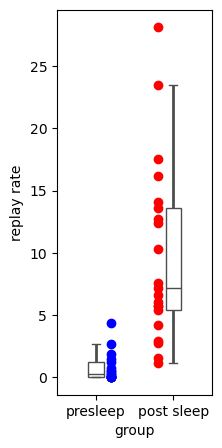

In [145]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

for epms in presleep_events_per_min:
    ax.plot(0.2,epms,'o', color = 'blue')
    
ps_rr = expert_master['reactivations_per_min']
ax.plot([0.8]*len(ps_rr),ps_rr,'o', color = 'red')

plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")


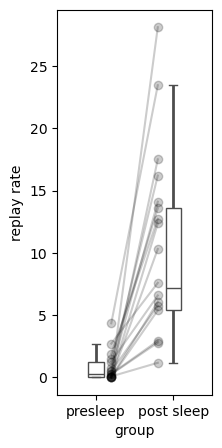

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in expert_master['animals']:
        post_events = np.array(expert_master['reactivations_per_min'])[np.array(expert_master['animals']) == mir][0]
        ax.plot([0.2,0.8],[pre_events,post_events],'o-', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate-connected.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

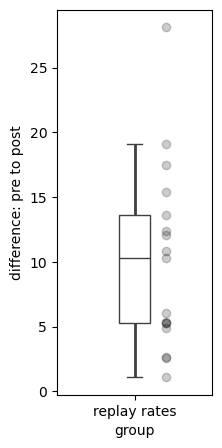

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
diffs = []
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in expert_master['animals']:
        post_events = np.array(expert_master['reactivations_per_min'])[np.array(expert_master['animals']) == mir][0]
        diff = post_events - pre_events
        diffs += [diff]
        ax.plot([0.2],diff,'o', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['replay rates'] * len(diffs)), 'difference: pre to post': diffs})
ax = sns.boxplot(y='difference: pre to post', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate-diff.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")


# firing rate control

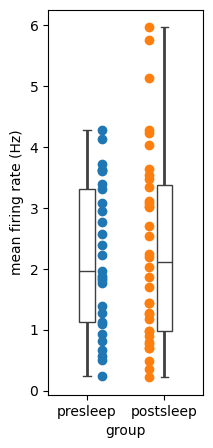

In [148]:
presleep_average_firing_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_average_firing_rates.csv")
postsleep_average_firing_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\average_firing_rates.csv")
postsleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\postsleep_event_details.csv")
presleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv")


bool_1 = []
for item in presleep_average_firing_rates.mirs:
    if item in presleep_event_details.mirs.values:
        bool_1 += [True]
    else:
        bool_1 += [False]
        
bool_2 = []
for item in postsleep_average_firing_rates.mirs:
    if item in postsleep_event_details.mirs.values:
        bool_2 += [True]
    else:
        bool_2 += [False]
        
pre = presleep_average_firing_rates[bool_1].average_firing_rates.values
post = postsleep_average_firing_rates[bool_2].average_firing_rates.values

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.2] * len(pre),pre,'o')
ax.plot([0.8] * len(post),post,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre))+(['postsleep'] * len(post)), 'mean firing rate (Hz)': list(pre)+list(post)})
ax = sns.boxplot(y='mean firing rate (Hz)', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('pre-post-firing-rate-control.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

# preprocess event details

In [7]:


PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"

# PP_PATH =  r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
number_of_spikes = []
event_lengths = []
number_of_neurons = []
mirs = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    chunk_number_of_spikes = []
    chunk_event_lengths = []
    chunk_number_of_neurons = []
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                filtered_replay_clusts = replay_clusts[replay_clusts.ordering_classification == 'sequential']
                chunk_number_of_spikes += [list(filtered_replay_clusts.num_spikes.values)]
                chunk_event_lengths += [list(filtered_replay_clusts.event_length.values)]
                n_neurons = []
                for clusters in filtered_replay_clusts.cluster_neurons:
                    n_neurons += [len(np.unique(literal_eval(clusters)))]
                chunk_number_of_neurons += [n_neurons]
                
    mirs += [file_.split('_run')[0]]
    number_of_spikes += [chunk_number_of_spikes]
    event_lengths += [chunk_event_lengths]
    number_of_neurons += [chunk_number_of_neurons]  
    
out_df = pd.DataFrame({'mirs':mirs,'number_of_spikes_per_event_per_chunk':number_of_spikes,'event_lengths_per_event_per_chunk':event_lengths,'number_of_neurons_per_event_per_chunk':number_of_neurons}) 
out_df.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv",index = False)

100%|██████████| 31/31 [06:02<00:00, 11.69s/it]


# load and plot

In [129]:
postsleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\postsleep_event_details.csv")
presleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv")


c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


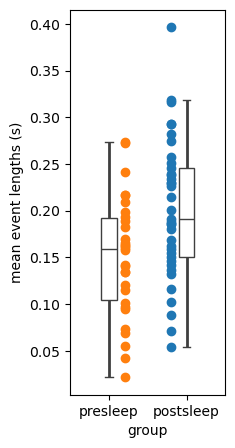

In [130]:
mean_neurons = []
for item in postsleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean event lengths (s)': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean event lengths (s)', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-event-length.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [131]:


# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#parametric

# ind t test
scipy.stats.ttest_ind(presleep_clean,post_clean)

ShapiroResult(statistic=np.float64(0.9854181555860531), pvalue=np.float64(0.9440877889687044))
ShapiroResult(statistic=np.float64(0.9890546809376314), pvalue=np.float64(0.9699504486195011))


TtestResult(statistic=np.float64(-2.952189100461933), pvalue=np.float64(0.00438617673174652), df=np.float64(65.0))

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


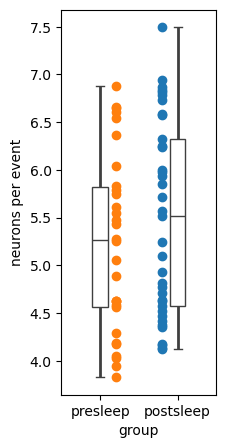

In [132]:
mean_neurons = []
for item in postsleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'neurons per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='neurons per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('neurons-per-event.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [ ]:

# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#non parametric

#indipendent, Wilcoxon Rank-Sum test
scipy.stats.ranksums(presleep_clean,post_clean)

ShapiroResult(statistic=np.float64(0.9426393607836691), pvalue=np.float64(0.10714487311900522))
ShapiroResult(statistic=np.float64(0.9191407241432415), pvalue=np.float64(0.01048400938724851))


RanksumsResult(statistic=np.float64(-1.0339237932144132), pvalue=np.float64(0.3011717908311138))

c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


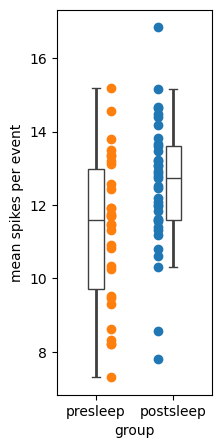

In [ ]:
mean_neurons = []
for item in postsleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean spikes per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean spikes per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('pre-post-spikes-per-event.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [ ]:

# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#parametric

# ind t test
scipy.stats.ttest_ind(presleep_clean,post_clean)

ShapiroResult(statistic=np.float64(0.9736347336727063), pvalue=np.float64(0.6425938122325177))
ShapiroResult(statistic=np.float64(0.9745358066407458), pvalue=np.float64(0.5444022319207653))


TtestResult(statistic=np.float64(-2.681469325508937), pvalue=np.float64(0.009281302676323199), df=np.float64(65.0))

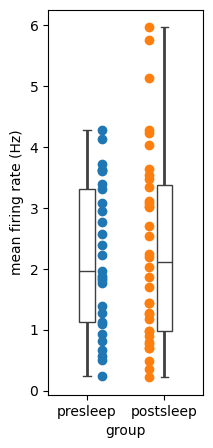

In [137]:


print(scipy.stats.shapiro(pre))
print(scipy.stats.shapiro(post))

#non parametric

#indipendent, Wilcoxon Rank-Sum test
scipy.stats.ranksums(pre,post)

ShapiroResult(statistic=np.float64(0.951025621714755), pvalue=np.float64(0.19460186435686688))
ShapiroResult(statistic=np.float64(0.9355716482703269), pvalue=np.float64(0.03704580296968984))


RanksumsResult(statistic=np.float64(-0.10557434432865279), pvalue=np.float64(0.9159200812258538))